In [9]:
import torch
import numpy as np
import gymnasium as gym
from matplotlib import pyplot as plt
from IPython.display import clear_output
from TD3 import TD3
from time import perf_counter

In [10]:
env_string = "Pendulum-v1"

In [11]:
def run(env, agent, n_episodes=100, noise=0):
    rewards = []
    observations = []
    actions = []
    for ep in range(1, n_episodes+1):
        start = perf_counter()
        ep_reward = 0
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state, noise)
            (next_state, reward, done, _trunc, _info) = env.step(action)

            done = _trunc or done
            transition = (state, action, reward, next_state, done)
            agent.store_transition(transition)

            state = next_state

            observations.append(state)
            actions.append(action)
            ep_reward += reward
            
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

In [20]:
def train(env, agent, n_episodes=1000, train_every=1):
    losses = []
    n_steps = n_episodes // train_every
    ep_per_step = train_every
    for i in range(n_steps):
        observations, actions, rewards = run(env, agent, n_episodes=ep_per_step, noise=0.2)
        losses.append(np.mean(agent.train()))
    return losses

In [21]:
env = gym.make(env_string)

In [22]:
agent = TD3(env.observation_space, env.action_space)

In [23]:
# run(env, agent, n_episodes=100, noise=0)

In [24]:
losses = train(env, agent)

Episode 1 finished in 0.12 seconds
Mean reward: -1695.3425514357245
Episode 1 finished in 0.01 seconds
Mean reward: -1720.7211053096285
Episode 1 finished in 0.01 seconds
Mean reward: -1771.9959222129366
Episode 1 finished in 0.01 seconds
Mean reward: -1714.242309826462
Episode 1 finished in 0.01 seconds
Mean reward: -1795.7525847866877
Episode 1 finished in 0.01 seconds
Mean reward: -1700.3410449245348
Episode 1 finished in 0.01 seconds
Mean reward: -1827.9995512283895
Episode 1 finished in 0.01 seconds
Mean reward: -1608.661029278653
Episode 1 finished in 0.01 seconds
Mean reward: -1594.4110587607795
Episode 1 finished in 0.01 seconds
Mean reward: -1597.8924302488788
Episode 1 finished in 0.01 seconds
Mean reward: -1597.1391746185475
Episode 1 finished in 0.01 seconds
Mean reward: -1604.3832478332167
Episode 1 finished in 0.01 seconds
Mean reward: -821.6966240099599
Episode 1 finished in 0.01 seconds
Mean reward: -1528.3716317036174
Episode 1 finished in 0.01 seconds
Mean reward: -11

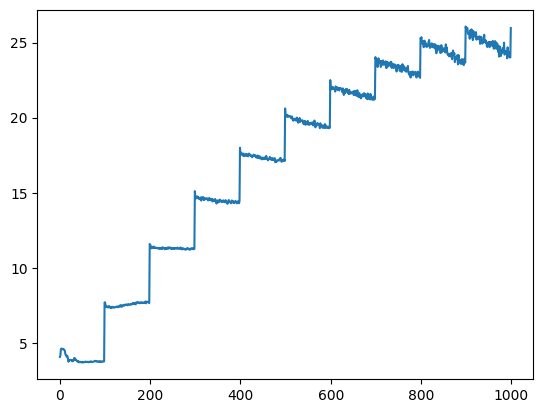

In [26]:
plt.plot(losses)

In [33]:
def play(env_string, agent, n_episodes=10, noise=0):
    rewards = []
    observations = []
    actions = []
    for ep in range(1, n_episodes+1):
        ep_reward = 0
        env = gym.make(env_string, render_mode='human')
        state, _info = env.reset()
        for t in range(2000):
            action = agent.act(state, noise)
            (next_state, reward, done, _trunc, _info) = env.step(action)

            done = _trunc or done

            state = next_state

            observations.append(state)
            actions.append(action)
            ep_reward += reward
            
            if done or _trunc:
                break
        rewards.append(ep_reward)
        ep_reward = 0
        env.close()
    observations = np.asarray(observations)
    actions = np.asarray(actions)
    return observations, actions, rewards

In [35]:
play("Pendulum-v1", agent)

(array([[ 9.6263719e-01,  2.7079448e-01, -3.9796817e-01],
        [ 9.6903479e-01,  2.4692433e-01, -4.9426484e-01],
        [ 9.7608000e-01,  2.1741164e-01, -6.0686225e-01],
        ...,
        [ 9.9906665e-01,  4.3195065e-02,  1.2188538e-07],
        [ 9.9906665e-01,  4.3195061e-02, -4.7702912e-08],
        [ 9.9906665e-01,  4.3195054e-02, -1.1402521e-07]], dtype=float32),
 array([[-1.99842989],
        [-1.9959501 ],
        [-1.9852711 ],
        ...,
        [-0.21597478],
        [-0.21597645],
        [-0.21597575]]),
 [-1.0441879628843593,
  -532.3588376226438,
  -269.51333960764003,
  -268.8768361173764,
  -560.4350978350982,
  -533.4090783297285,
  -516.5170364878351,
  -380.8690809560955,
  -136.31986976644004,
  -2.543339756036772])